In [1]:
%matplotlib inline

import pymc3 as pm
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from collections import defaultdict, Counter
import csv

sb.set()

np.set_printoptions(suppress=True, precision=2, threshold=8)

### Lettura dati sul voto

Leggo i voti delle Politiche 2018, e le trasformo in una tabella id_seggio -> {partito: voti}

In [2]:
voti = pd.read_csv("../../data/raw/scrutiniCI_cm.csv")

voti = voti[["codice", "descr_lista", "voti"]]
voti = voti.dropna(subset=["codice", "descr_lista"])

voti = voti.pivot(index='codice', columns='descr_lista', values='voti').fillna(0)

partiti2sigla = {
 '+EUROPA': '+E',
 'FORZA ITALIA': 'FI',
 "FRATELLI D'ITALIA CON GIORGIA MELONI": 'FdI',
 'LEGA': 'LEGA',
 'LIBERI E UGUALI': 'LeU',
 'MOVIMENTO 5 STELLE': 'M5S',
 'PARTITO DEMOCRATICO': 'PD',
 'POTERE AL POPOLO!': 'PaP'
}

voti = voti[list(partiti2sigla.keys())]
voti = voti.rename(partiti2sigla, axis=1)
partiti = list(partiti2sigla.values())

for p in partiti:
    voti[p] = pd.to_numeric(voti[p], errors='coerce').fillna(0).astype(int)
    assert not any(voti[p].isnull())

voti.head()


descr_lista,+E,FI,FdI,LEGA,LeU,M5S,PD,PaP
codice,,,,,,,,
1110812620,12970,15055,5056,15783,7303,19402,33228,2576
1120812620,3527,11604,2880,20678,4239,27831,21849,1311
1130812620,7457,14632,4893,19791,6233,28149,30956,1843
1140812620,5351,12416,4136,18597,5517,29751,30278,1265
1150810080,406,1095,340,1683,425,3404,2073,110


Trasformo l'id del seggio nel comune, come codice istat e come nome, attraverso la tabella apposita.
Qui aggiungo anche la regione.

In [3]:
comune_seggi = pd.read_csv("../../data/raw/comuniViminaleISTAT.csv", encoding='latin')[
    ['PRO_COM', 'ELIGENDO_C_UID_CI', 'REGIONE', 'ELIGENDO_C_NOME']
]
comune_seggi = comune_seggi.dropna()
comune_seggi['ELIGENDO_C_UID_CI'] = comune_seggi['ELIGENDO_C_UID_CI'].astype(int)

assert not any(comune_seggi['PRO_COM'].duplicated())
assert not any(comune_seggi['ELIGENDO_C_UID_CI'].duplicated())

voti = pd.merge(voti, comune_seggi, left_index=True,
                 right_on='ELIGENDO_C_UID_CI',
                 validate="one_to_one"
                ).rename({'PRO_COM': 'comune', 'ELIGENDO_C_NOME': 'nome_comune', 'REGIONE': 'regione'}, axis=1)
del voti['ELIGENDO_C_UID_CI']
voti = voti[['comune', 'regione', 'nome_comune'] + partiti]
voti.head()

,comune,regione,nome_comune,+E,FI,FdI,LEGA,LeU,M5S,PD,PaP
178,1008,Piemonte,ALPIGNANO,406,1095,340,1683,425,3404,2073,110
590,1024,Piemonte,BEINASCO,288,1091,273,1832,436,3729,2508,121
948,1038,Piemonte,BRUINO,135,658,172,992,215,1705,1091,53
2217,1090,Piemonte,COLLEGNO,1062,2518,891,4798,1864,9472,7076,259
2586,1099,Piemonte,DRUENTO,181,564,171,1105,206,1557,1076,46


Dalla regione, aggiungo l'area geografica.

In [4]:
regione2area = {
 'Piemonte': 'Nord',
 'Lombardia': 'Nord',
 'Veneto': 'Nord',
 'Friuli-Venezia Giulia': 'Nord',
 'Liguria': 'Nord',
 'Emilia-Romagna': 'Centro',
 'Toscana': 'Centro',
 'Umbria': 'Centro',
 'Marche': 'Centro',
 'Lazio': 'Centro',
 'Abruzzo': 'Sud',
 'Molise': 'Sud',
 'Campania': 'Sud',
 'Puglia': 'Sud',
 'Basilicata': 'Sud',
 'Calabria': 'Sud',
 'Sicilia': 'Sud',
 'Sardegna': 'Sud',
 "Valle d'Aosta/VallÃ©e d'Aoste": 'Autonomista',
 'Trentino-Alto Adige/SÃ¼dtirol': 'Autonomista',
}
voti['area'] = voti.regione.apply(regione2area.__getitem__)
voti = voti[['comune', 'nome_comune', 'area', 'regione'] + partiti]
voti.head()

,comune,nome_comune,area,regione,+E,FI,FdI,LEGA,LeU,M5S,PD,PaP
178,1008,ALPIGNANO,Nord,Piemonte,406,1095,340,1683,425,3404,2073,110
590,1024,BEINASCO,Nord,Piemonte,288,1091,273,1832,436,3729,2508,121
948,1038,BRUINO,Nord,Piemonte,135,658,172,992,215,1705,1091,53
2217,1090,COLLEGNO,Nord,Piemonte,1062,2518,891,4798,1864,9472,7076,259
2586,1099,DRUENTO,Nord,Piemonte,181,564,171,1105,206,1557,1076,46


Ora devo aggiungere il numero di *aventi diritto*, per semplicità che prendo da quello delle Europee.

In [5]:
elettori = pd.read_csv("../../data/raw/europee2019_elettori_votanti_italia.csv", encoding='latin', sep=';')

voti_con_elettori = pd.merge(voti, elettori[['COMUNE', 'ELETT_TOT']],
                 left_on='nome_comune', right_on='COMUNE',
                 how='left', indicator=True)

print(len(voti_con_elettori[voti_con_elettori._merge == 'left_only'].nome_comune.unique()),
      'comuni non trovati su',
      len(voti_con_elettori.nome_comune.unique()),
     ': perlopiù sono comuni istituiti nel 2018/19')

voti_con_elettori = voti_con_elettori[voti_con_elettori._merge == 'both']
del voti_con_elettori['COMUNE']
del voti_con_elettori['_merge']
voti_con_elettori = voti_con_elettori.rename({'ELETT_TOT': 'elettori'}, axis=1)
voti_con_elettori.elettori = voti_con_elettori.elettori.astype(int)
voti_con_elettori['Non voto'] = (
    voti_con_elettori.elettori - sum(voti_con_elettori[c] for c in partiti)).clip(lower=0)
voti_con_elettori.head()


85 comuni non trovati su 7941 : perlopiù sono comuni istituiti nel 2018/19


,comune,nome_comune,area,regione,+E,FI,FdI,LEGA,LeU,M5S,PD,PaP,elettori,Non voto
0,1008,ALPIGNANO,Nord,Piemonte,406,1095,340,1683,425,3404,2073,110,13958,4422
1,1024,BEINASCO,Nord,Piemonte,288,1091,273,1832,436,3729,2508,121,14569,4291
2,1038,BRUINO,Nord,Piemonte,135,658,172,992,215,1705,1091,53,6955,1934
3,1090,COLLEGNO,Nord,Piemonte,1062,2518,891,4798,1864,9472,7076,259,40457,12517
4,1099,DRUENTO,Nord,Piemonte,181,564,171,1105,206,1557,1076,46,7136,2230


### Lettura dati sul reddito

Ora devo leggere i dati sul reddito, comune per comune, forniti dall'ISTAT.

In [6]:
istat = pd.read_csv("../../data/raw/Redditi_e_principali_variabili_IRPEF_su_base_comunale_CSV_2017.csv", sep=';')
reddito_colonne = [c for c in istat.columns if 'Reddito complessivo' in c and 'Frequenza' in c]
reddito_colonne

['Reddito complessivo minore o uguale a zero euro - Frequenza',
 'Reddito complessivo da 0 a 10000 euro - Frequenza',
 'Reddito complessivo da 10000 a 15000 euro - Frequenza',
 'Reddito complessivo da 15000 a 26000 euro - Frequenza',
 'Reddito complessivo da 26000 a 55000 euro - Frequenza',
 'Reddito complessivo da 55000 a 75000 euro - Frequenza',
 'Reddito complessivo da 75000 a 120000 euro - Frequenza',
 'Reddito complessivo oltre 120000 euro - Frequenza']

In [7]:
istat = istat[['Codice Istat Comune'] + reddito_colonne].fillna(0).astype(int)

voti_redditi = pd.merge(voti_con_elettori, istat,
                        left_on='comune',
                        right_on='Codice Istat Comune',
                        how='left',
                        indicator=True)

print(len(voti_redditi[voti_redditi._merge != 'both'].nome_comune.unique()), 'comuni',
      'su', len(voti_redditi.nome_comune.unique()),'non hanno dati sul reddito.')

voti_redditi = voti_redditi[voti_redditi._merge == 'both']
del voti_redditi['_merge']
del voti_redditi['Codice Istat Comune']

voti_redditi['Non contribuenti'] = (voti_redditi.elettori - sum(voti_redditi[c] for c in reddito_colonne)
                                   ).clip(lower=0)
voti_redditi.head()

156 comuni su 7856 non hanno dati sul reddito.


,comune,nome_comune,area,regione,+E,FI,FdI,LEGA,LeU,M5S,...,Non voto,Reddito complessivo minore o uguale a zero euro - Frequenza,Reddito complessivo da 0 a 10000 euro - Frequenza,Reddito complessivo da 10000 a 15000 euro - Frequenza,Reddito complessivo da 15000 a 26000 euro - Frequenza,Reddito complessivo da 26000 a 55000 euro - Frequenza,Reddito complessivo da 55000 a 75000 euro - Frequenza,Reddito complessivo da 75000 a 120000 euro - Frequenza,Reddito complessivo oltre 120000 euro - Frequenza,Non contribuenti
0,1008,ALPIGNANO,Nord,Piemonte,406,1095,340,1683,425,3404,...,4422,85.0,2437.0,1432.0,4473.0,3171.0,239.0,169.0,67.0,1885.0
1,1024,BEINASCO,Nord,Piemonte,288,1091,273,1832,436,3729,...,4291,80.0,2738.0,1721.0,4918.0,3390.0,223.0,127.0,44.0,1328.0
2,1038,BRUINO,Nord,Piemonte,135,658,172,992,215,1705,...,1934,60.0,1261.0,641.0,2016.0,1756.0,175.0,109.0,49.0,888.0
3,1090,COLLEGNO,Nord,Piemonte,1062,2518,891,4798,1864,9472,...,12517,291.0,7354.0,4162.0,12579.0,10326.0,859.0,507.0,166.0,4213.0
4,1099,DRUENTO,Nord,Piemonte,181,564,171,1105,206,1557,...,2230,42.0,1280.0,767.0,2145.0,1670.0,151.0,82.0,41.0,958.0


Semplifico le classi di reddito, riducendole a 5.

In [8]:
definizione_classi = {
 'Sotto 15000€': [
    'Reddito complessivo minore o uguale a zero euro - Frequenza',
    'Reddito complessivo da 0 a 10000 euro - Frequenza',
    'Reddito complessivo da 10000 a 15000 euro - Frequenza'
 ],
 'Sotto 26000€': ['Reddito complessivo da 15000 a 26000 euro - Frequenza'],
 'Sotto 55000€': ['Reddito complessivo da 26000 a 55000 euro - Frequenza'],
 'Sotto 75000€': ['Reddito complessivo da 55000 a 75000 euro - Frequenza'],
 'Oltre': [
     'Reddito complessivo da 75000 a 120000 euro - Frequenza',
     'Reddito complessivo oltre 120000 euro - Frequenza'
 ]}

classi = list(definizione_classi.keys())

for classe in classi:
    voti_redditi[classe] = sum([voti_redditi[c] for c in definizione_classi[classe]])
    for c in definizione_classi[classe]:
        del voti_redditi[c]

    
voti_redditi.head()

,comune,nome_comune,area,regione,+E,FI,FdI,LEGA,LeU,M5S,PD,PaP,elettori,Non voto,Non contribuenti,Sotto 15000€,Sotto 26000€,Sotto 55000€,Sotto 75000€,Oltre
0,1008,ALPIGNANO,Nord,Piemonte,406,1095,340,1683,425,3404,2073,110,13958,4422,1885.0,3954.0,4473.0,3171.0,239.0,236.0
1,1024,BEINASCO,Nord,Piemonte,288,1091,273,1832,436,3729,2508,121,14569,4291,1328.0,4539.0,4918.0,3390.0,223.0,171.0
2,1038,BRUINO,Nord,Piemonte,135,658,172,992,215,1705,1091,53,6955,1934,888.0,1962.0,2016.0,1756.0,175.0,158.0
3,1090,COLLEGNO,Nord,Piemonte,1062,2518,891,4798,1864,9472,7076,259,40457,12517,4213.0,11807.0,12579.0,10326.0,859.0,673.0
4,1099,DRUENTO,Nord,Piemonte,181,564,171,1105,206,1557,1076,46,7136,2230,958.0,2089.0,2145.0,1670.0,151.0,123.0


## Il modello

Considerando un solo comune, dove il partito i ha preso voti $V_i$ e la classe j ha $X_j$ membri:

$V_i \sim \mathcal{N}( \sum_{j} p_{i, j} \cdot X_j, \sigma)$

dove per ogni classe $j$ vale $\sum_i p_{i, j} = 1$ (considerando il partito dell'astensione).

In [9]:
def run_mcmc(df, area, num_abitanti_massimo=100000, partiti=partiti, classi=classi):
    num_partiti = len(partiti) + 1 # Il non voto.
    num_classes = len(classi) + 1 # I non contribuenti
    
    df_area = df[df['area'] == area]
    df_area = df_area[df_area.elettori < num_abitanti_massimo]
    
    X = df_area[['Non contribuenti'] + classi].values
    Y = df_area[['Non voto'] + partiti].values

    B = 10 # Iperparametro (concentrazione della Dirichlet).

    with pm.Model() as model:
        sigma = np.mean(0.05 * np.sum(X, axis=1)) * pm.HalfCauchy('sigma', beta=10, testval=1.)
        p = [
            pm.Dirichlet(f'p{j}', a=np.array([B] * num_partiti), shape=num_partiti)
            for j in range(num_classes)
        ]
        votes_forecast = sum([
            p[i] * np.tile(np.array([X[:, i]]).T, reps=num_partiti)
            for i in range(num_classes)
        ])
        likelihood = pm.Normal('y', mu=votes_forecast, sigma=sigma, observed=Y)
        trace = pm.sample(5000, cores=3) # draw 3000 posterior samples using NUTS sampling
        return trace


Questo richiede parecchio tempo... ⏳

In [10]:
area2results = {area: run_mcmc(voti_redditi, area) for area in ['Nord', 'Centro', 'Sud']}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [p5, p4, p3, p2, p1, p0, sigma]
Sampling 3 chains: 100%|██████████| 16500/16500 [1:08:44<00:00,  2.28draws/s]
The acceptance probability does not match the target. It is 0.9179454652452004, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [p5, p4, p3, p2, p1, p0, sigma]
Sampling 3 chains: 100%|██████████| 16500/16500 [17:40<00:00, 10.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [p5, p4, p3, p2, p1, p0, sigma]
Sampling 3 chains: 100%|██████████| 16500/16500 [24:05<00:00,  6.19draws/s]


# Risultati (Politiche 2018)

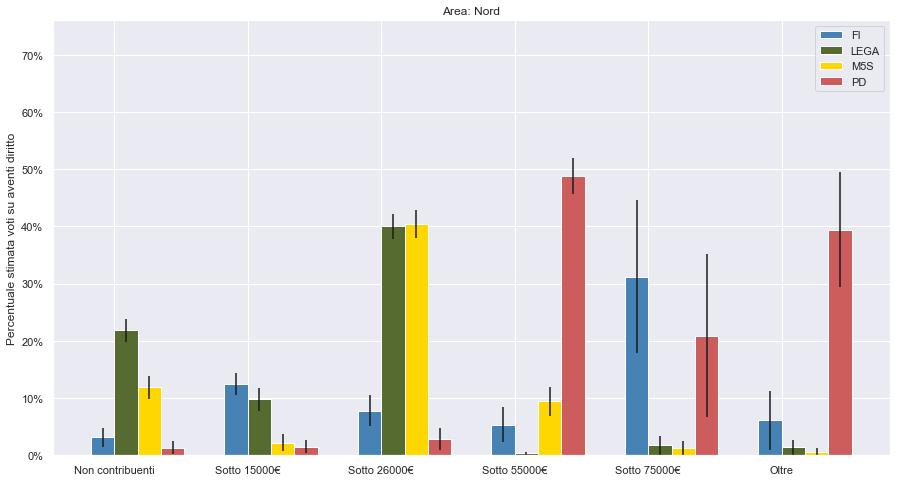

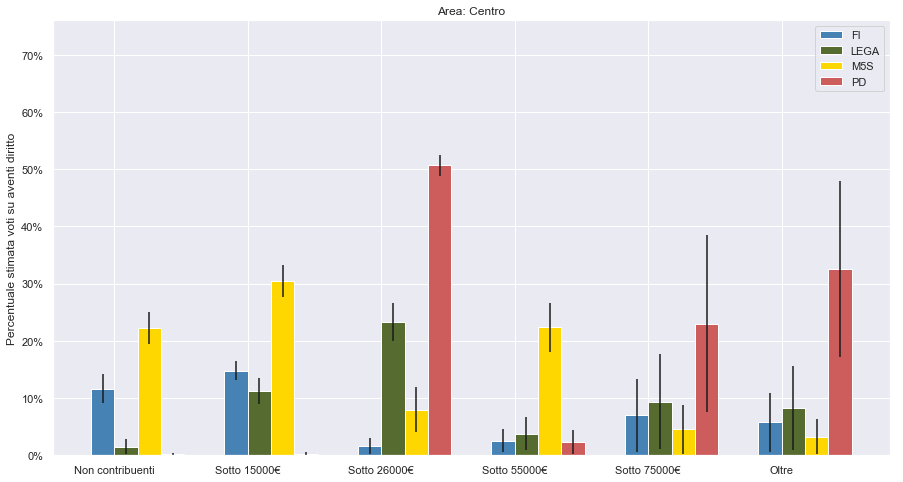

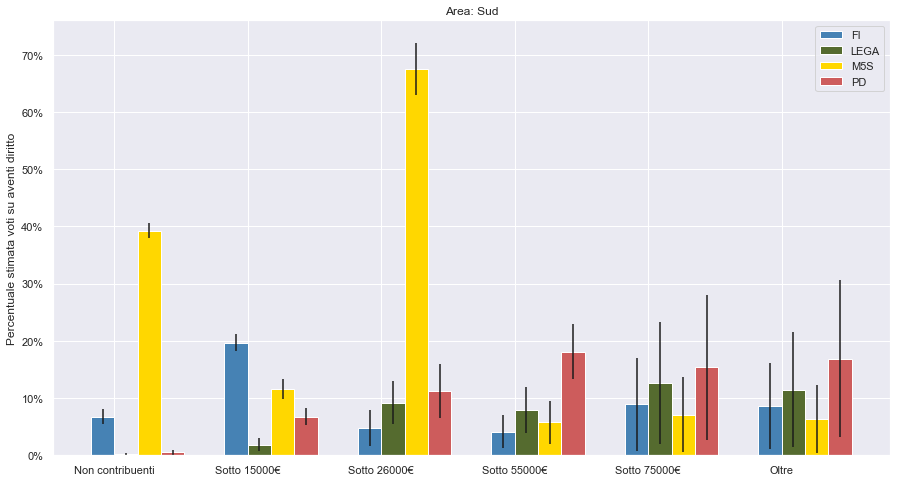

In [16]:
num_partiti = len(partiti) + 1 # Il non voto.
num_classes = len(classi) + 1 # I non contribuenti

def get_mean_and_err_for(area, partito):
    assert partito in partiti
    idx_partito = partiti.index(partito) + 1
    samples = np.array([[t[f'p{j}'][idx_partito] for t in area2results[area]] for j in range(num_classes)]).T
    return np.mean(samples, axis=0), np.std(samples, axis=0)

def plot(area, partiti_colori, ylims=(0, 0.76, 0.1), path=None):
    trace = area2results[area]
    fig, ax = plt.subplots(figsize=(15, 8))
     
    ind = np.arange(num_classes)  # the x locations for the groups
    width = 0.7 / max(4, len(partiti_colori))       # the width of the bars
    
    for i, (partito, color) in enumerate(partiti_colori):
        means, std = get_mean_and_err_for(area, partito)
        rects1 = ax.bar(ind + i * width, means, width, color=color, yerr=3 * std, label=partito)

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Percentuale stimata voti su aventi diritto')
    ax.set_title(f'Area: {area}')
    yticks = np.arange(*ylims)
    ax.set_yticks(yticks)
    ax.set_yticklabels([ (str(int(y*100)) + "%") for y in yticks])
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(['Non contribuenti'] + classi)
    ax.set_ylim(ylims[:2])

    ax.legend()
    if path:
        plt.savefig(path)
    plt.show()
    
for area in ['Nord', 'Centro', 'Sud']:
    plot(area, [
         ('FI', 'steelblue'),
         ('LEGA', 'darkolivegreen'),
         ('M5S', 'gold'),
         ('PD', 'indianred'),
    ], path=f'2018-politiche-big-{area}.pdf')

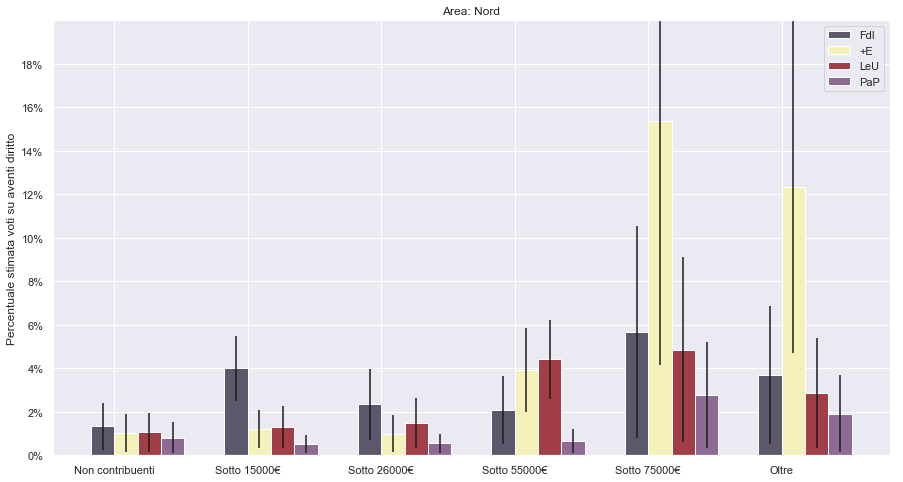

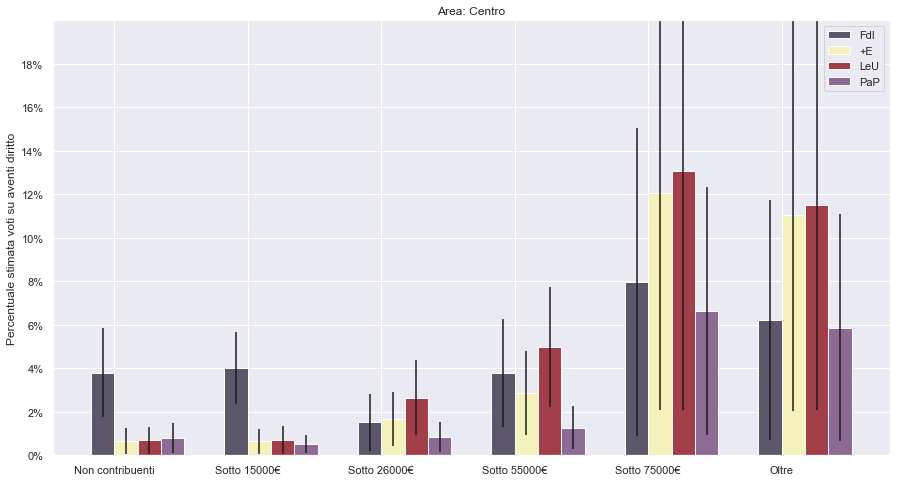

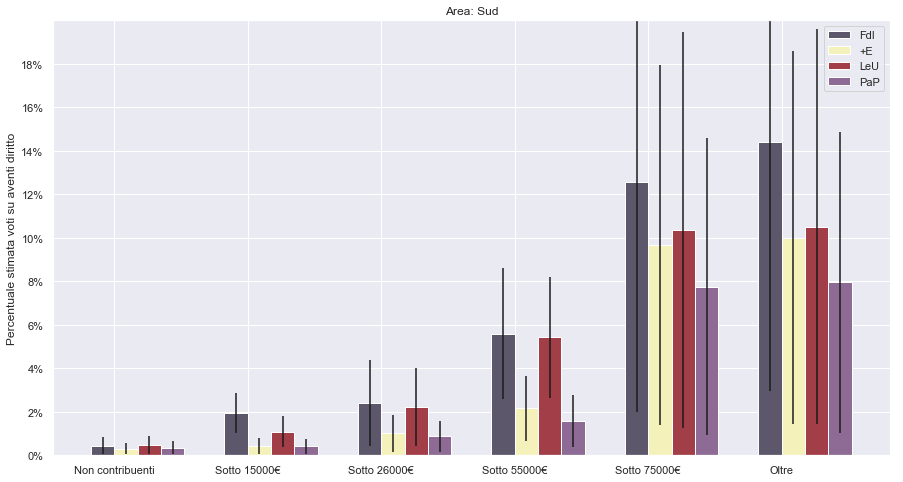

In [18]:
for area in ['Nord', 'Centro', 'Sud']:
    plot(area, [
         ('FdI', '#5d576b'),
         ('+E', '#f4f1bb'),
         ('LeU', '#a23e48'),
         ('PaP', '#8d6b94'),
    ], ylims=(0, 0.2, 0.02), path=f'2018-politiche-small-{area}.pdf')

In [22]:
voti_europee = pd.read_csv("../../data/raw/europee2019_scrutini_area_italia.csv", encoding='Latin-1', delimiter=";")

In [25]:
comune_seggi.columns

Index(['PRO_COM', 'ELIGENDO_C_UID_CI', 'REGIONE', 'ELIGENDO_C_NOME'], dtype='object')

In [28]:
merged = pd.merge(voti_europee, comune_seggi, left_on='COMUNE', right_on='ELIGENDO_C_NOME',
        how='left', indicator=True)

In [36]:
comune_seggi

,PRO_COM,ELIGENDO_C_UID_CI,REGIONE,ELIGENDO_C_NOME
0,28001,8130540010,Veneto,ABANO TERME
1,98001,6130990010,Lombardia,ABBADIA CERRETO
2,97001,4250980010,Lombardia,ABBADIA LARIANA
3,52001,12420750010,Toscana,ABBADIA SAN SALVATORE
4,95001,26210950010,Sardegna,ABBASANTA
5,68001,17120600010,Abruzzo,ABBATEGGIO
6,15002,3410490020,Lombardia,ABBIATEGRASSO
7,47023,12120630012,Toscana,ABETONE CUTIGLIANO
8,76001,22110640010,Basilicata,ABRIOLA
9,88001,25320650010,Sicilia,ACATE


In [35]:
list(merged[merged._merge != 'both']['COMUNE'].unique())

['GENOVA',
 'SOLBIATE CON CAGNO',
 'PIADENA DRIZZONA',
 'BORGOCARBONARA',
 'SAN GIORGIO BIGARELLO',
 'MILANO',
 'VERMEZZO CON ZELO',
 'COLLI VERDI',
 'CADREZZATE CON OSMATE',
 'LU E CUCCARO MONFERRATO',
 'QUAREGNA CERRETO',
 'VALDILANA',
 'GATTICO-VERUNO',
 'TORINO',
 'VAL DI CHY',
 'VALCHIUSA',
 'VALLE CANNOBINA',
 'EMARÔSE',
 'F\x90NIS',
 'VERRÔS',
 'BOLOGNA',
 'RIVA DEL PO',
 'TRESIGNANA',
 'SORBOLO MEZZANI',
 "FIE' ALLO SCILIAR/V\x99LS AM SCHLERN",
 'FUNES/VILLN\x99SS',
 'LUSON/L\x9aSEN',
 'MELTINA/M\x99LTEN',
 'RIO DI PUSTERIA/M\x9aHLBACH',
 'SANTA CRISTINA VALGARDENA/ST. CHRISTINA IN GR\x99DEN',
 'SELVA DEI MOLINI/M\x9aHLWALD',
 'SELVA DI VAL GARDENA/WOLKENSTEIN IN GR\x99DEN',
 'TUBRE/TAUFERS IM M\x9aNSTERTAL',
 'VERANO/V\x99RAN',
 'SAN GIOVANNI DI FASSA',
 "TERRE D'ADIGE",
 'BORGO VALBELLUNA',
 'BORGO VENETO',
 'PIEVE DEL GRAPPA',
 'NEGRAR DI VALPOLICELLA',
 'BARBARANO MOSSANO',
 'COLCERESA',
 'LUSIANA CONCO',
 'VALBRENTA',
 'ROMA',
 'SASSOCORVARO AUDITORE',
 'BARBERINO TAVARNEL

In [52]:
comune_seggi[comune_seggi.ELIGENDO_C_NOME == 'Milano']

,PRO_COM,ELIGENDO_C_UID_CI,REGIONE,ELIGENDO_C_NOME


In [ ]:
comune_seggi.